# Trabalho 5 - Transformada de Hough

Faça um documento jupyter notebook que forneça, com base na transformada de Hough modelada para círculos, a contagem e a descrição (coordenadas dos centros e raio) dos discos grandes presentes na imagem do exemplo (do trabalho 3 - segmentação dos discos claros usando a transformada top-hat). 

-------

Procedimento sugerido:

Use como base o resultado do trabalho 3. Inicialmente, subtraia o resultado do trabalho 3 da imagem original a fim de obter a segmentação dos discos. Em seguida, utilize um filtro para obter as bordas dos discos e binarize o resultado. Por fim, empregue a transformada de Hough para obter as informações desejadas.

-------

In [1]:
import cv2 as cv
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

## Carregando as images

In [2]:
cosmos_entrada = cv.imread('../images/cosmos_original.jpg', 0)
cosmos_saida = cv.imread('../images/img_final.jpg', 0)

In [3]:
cosmos_diff = cosmos_entrada - cosmos_saida

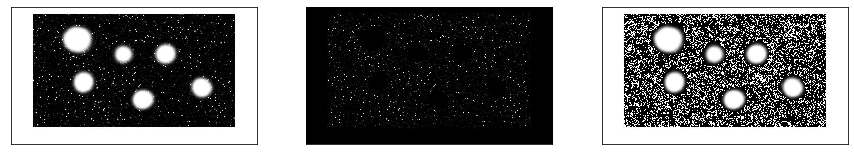

In [4]:
fig = plt.figure(figsize = (15, 9))

grid = plt.GridSpec(1, 3, fig)

ax0 = fig.add_subplot(grid[0, 0])
ax1 = fig.add_subplot(grid[0, 1])
ax2 = fig.add_subplot(grid[0, 2])

ax0.imshow(cosmos_entrada, cmap = 'gray')
ax0.set_xticks([])
ax0.set_yticks([])

ax1.imshow(cosmos_saida, cmap = 'gray')
ax1.set_xticks([])
ax1.set_yticks([])

ax2.imshow(cosmos_diff, cmap = 'gray')
ax2.set_xticks([])
ax2.set_yticks([])

plt.show()

In [95]:
cosmos_entrada_bin = img2binary(cosmos_entrada)

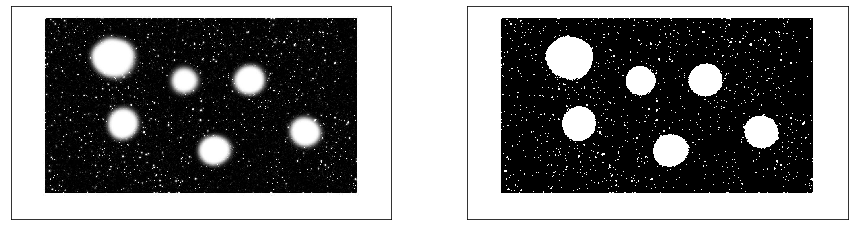

In [96]:
fig = plt.figure(figsize = (15, 9))

grid = plt.GridSpec(1, 2, fig)

ax0 = fig.add_subplot(grid[0, 0])
ax1 = fig.add_subplot(grid[0, 1])

ax0.imshow(cosmos_entrada, cmap = 'gray')
ax0.set_xticks([])
ax0.set_yticks([])

ax1.imshow(cosmos_entrada_bin, cmap = 'gray')
ax1.set_xticks([])
ax1.set_yticks([])

plt.show()

In [97]:
cosmos_saida_bin = img2binary(cosmos_saida)

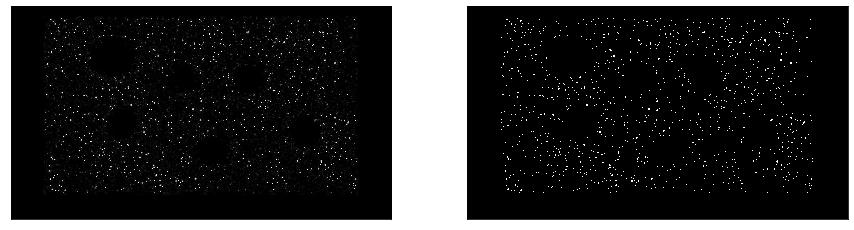

In [98]:
fig = plt.figure(figsize = (15, 9))

grid = plt.GridSpec(1, 2, fig)

ax0 = fig.add_subplot(grid[0, 0])
ax1 = fig.add_subplot(grid[0, 1])

ax0.imshow(cosmos_saida, cmap = 'gray')
ax0.set_xticks([])
ax0.set_yticks([])

ax1.imshow(cosmos_saida_bin, cmap = 'gray')
ax1.set_xticks([])
ax1.set_yticks([])

plt.show()

In [100]:
median_entrada = cv.medianBlur(cosmos_entrada_bin.astype(np.uint8), 5)
median_saida = cv.medianBlur(cosmos_saida_bin.astype(np.uint8), 5)
cosmos_diff_median = median_entrada - median_saida

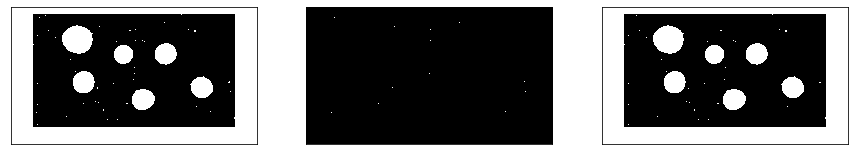

In [101]:
fig = plt.figure(figsize = (15, 9))

grid = plt.GridSpec(1, 3, fig)

ax0 = fig.add_subplot(grid[0, 0])
ax1 = fig.add_subplot(grid[0, 1])
ax2 = fig.add_subplot(grid[0, 2])

ax0.imshow(median_entrada, cmap = 'gray')
ax0.set_xticks([])
ax0.set_yticks([])

ax1.imshow(median_saida, cmap = 'gray')
ax1.set_xticks([])
ax1.set_yticks([])

ax2.imshow(cosmos_diff_median, cmap = 'gray')
ax2.set_xticks([])
ax2.set_yticks([])

plt.show()

In [102]:
cosmos_sob = sobel(cosmos_diff_median)

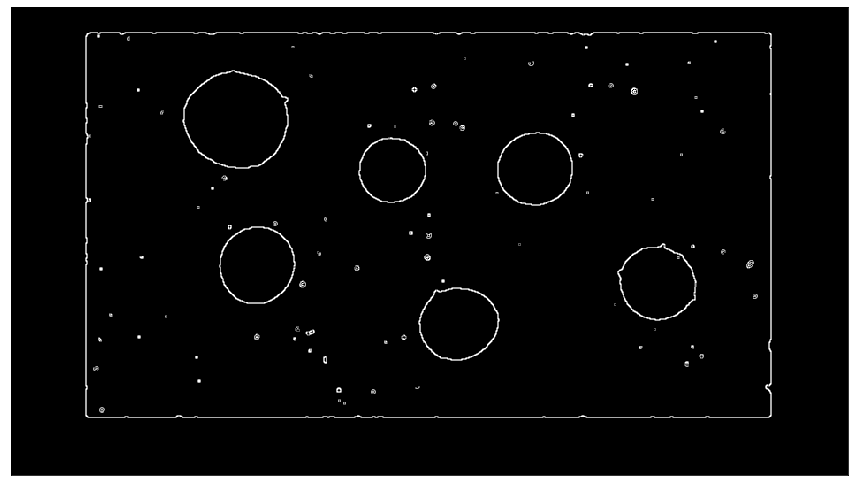

In [103]:
fig = plt.figure(figsize = (15, 9))

grid = plt.GridSpec(1, 1, fig)

ax0 = fig.add_subplot(grid[0, 0])

ax0.imshow(cosmos_sob, cmap = 'gray')
ax0.set_xticks([])
ax0.set_yticks([])

plt.show()

In [5]:
def img2binary(img, threshold = 60):
    """Binarization of image with threshold given"""
    return threshold < img

In [6]:
def roberts(img):
    """Apply Roberts filter to image"""
    k_robertsx = np.array([[1, 0], [0, -1]])
    k_robertsy = np.array([[0, 1], [-1, 0]])
    robertsx = cv.convertScaleAbs(cv.filter2D(img, cv.CV_64F, cv.flip(k_robertsx, -1)))
    robertsy = cv.convertScaleAbs(cv.filter2D(img, cv.CV_64F, cv.flip(k_robertsy, -1)))
    
    return robertsx + robertsy

In [46]:
def sobel(img):
    sobelx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobely = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    gx = cv.convertScaleAbs(cv.filter2D(img, cv.CV_64F, cv.flip(sobelx, -1)))
    gy = cv.convertScaleAbs(cv.filter2D(img, cv.CV_64F, cv.flip(sobely, -1)))
    
    return gx + gy

In [25]:
def binary_roberts(img, threshold = 60):
    """Returns roberts image in binary scale"""
    return img2binary(roberts(img), threshold).astype(np.uint8)

In [50]:
cosmos_test_0 = img2binary(cosmos_diff, 10)
cosmos_test_1 = img2binary(cosmos_diff, 100)
cosmos_test_2 = img2binary(cosmos_diff, 200)

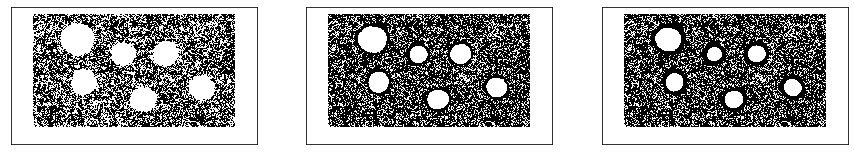

In [33]:
fig = plt.figure(figsize = (15, 9))

grid = plt.GridSpec(1, 3, fig)

ax0 = fig.add_subplot(grid[0, 0])
ax1 = fig.add_subplot(grid[0, 1])
ax2 = fig.add_subplot(grid[0, 2])

ax0.imshow(cosmos_test_0, cmap = 'gray')
ax0.set_xticks([])
ax0.set_yticks([])

ax1.imshow(cosmos_test_1, cmap = 'gray')
ax1.set_xticks([])
ax1.set_yticks([])

ax2.imshow(cosmos_test_2, cmap = 'gray')
ax2.set_xticks([])
ax2.set_yticks([])

plt.show()


In [51]:
cosmos_rob = roberts(cosmos_test_0.astype(np.uint8))
cosmos_sob = sobel(cosmos_test_0.astype(np.uint8))

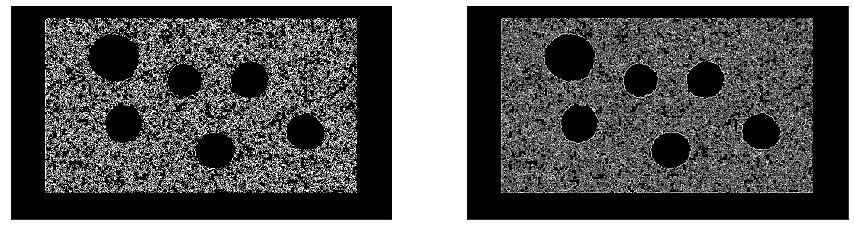

In [52]:
fig = plt.figure(figsize = (15, 9))

grid = plt.GridSpec(1, 2, fig)

ax0 = fig.add_subplot(grid[0, 0])
ax1 = fig.add_subplot(grid[0, 1])

ax0.imshow(cosmos_rob, cmap = 'gray')
ax0.set_xticks([])
ax0.set_yticks([])

ax1.imshow(cosmos_sob, cmap = 'gray')
ax1.set_xticks([])
ax1.set_yticks([])

plt.show()

In [64]:
median_rob = cv.medianBlur(cosmos_rob, 3)
median_sob = cv.medianBlur(cosmos_sob, 3)

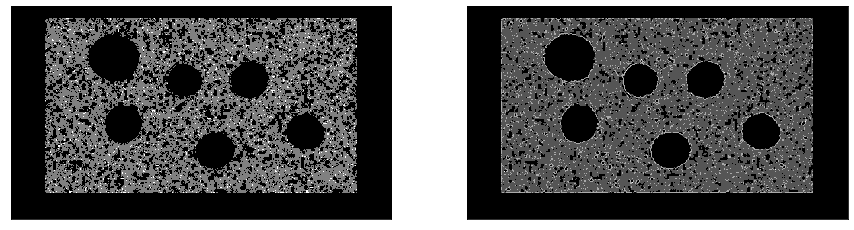

In [65]:
fig = plt.figure(figsize = (15, 9))

grid = plt.GridSpec(1, 2, fig)

ax0 = fig.add_subplot(grid[0, 0])
ax1 = fig.add_subplot(grid[0, 1])

ax0.imshow(median_rob, cmap = 'gray')
ax0.set_xticks([])
ax0.set_yticks([])

ax1.imshow(median_sob, cmap = 'gray')
ax1.set_xticks([])
ax1.set_yticks([])

plt.show()

In [68]:
median_diff = cv.medianBlur(cosmos_diff, 3)

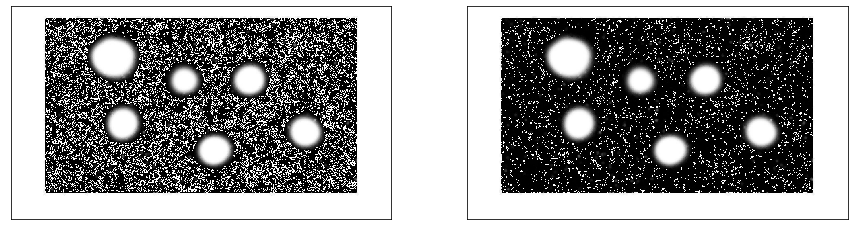

In [71]:
fig = plt.figure(figsize = (15, 9))

grid = plt.GridSpec(1, 2, fig)

ax0 = fig.add_subplot(grid[0, 0])
ax1 = fig.add_subplot(grid[0, 1])

ax0.imshow(cosmos_diff, cmap = 'gray')
ax0.set_xticks([])
ax0.set_yticks([])

ax1.imshow(median_diff, cmap = 'gray')
ax1.set_xticks([])
ax1.set_yticks([])

plt.show()

In [80]:
cosmos_test_0 = img2binary(median_diff, 50)

In [81]:
cosmos_rob_1 = roberts(cosmos_test_0.astype(np.uint8))
cosmos_sob_1 = sobel(cosmos_test_0.astype(np.uint8))

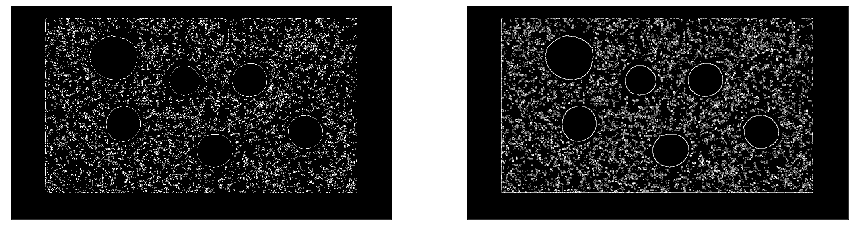

In [82]:
fig = plt.figure(figsize = (15, 9))

grid = plt.GridSpec(1, 2, fig)

ax0 = fig.add_subplot(grid[0, 0])
ax1 = fig.add_subplot(grid[0, 1])

ax0.imshow(cosmos_rob_1, cmap = 'gray')
ax0.set_xticks([])
ax0.set_yticks([])

ax1.imshow(cosmos_sob_1, cmap = 'gray')
ax1.set_xticks([])
ax1.set_yticks([])

plt.show()

Estratégia:

    1) Binarizar a entrada e a saída;
    2) Passar filtro mediano na entrada e na saída;
    3) Fazer a diferença entra entrada e saída;
    4) Aplicar Sobel na diferença;